In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

from data_utlis import *

cudnn.benchmark = True
plt.ion() 

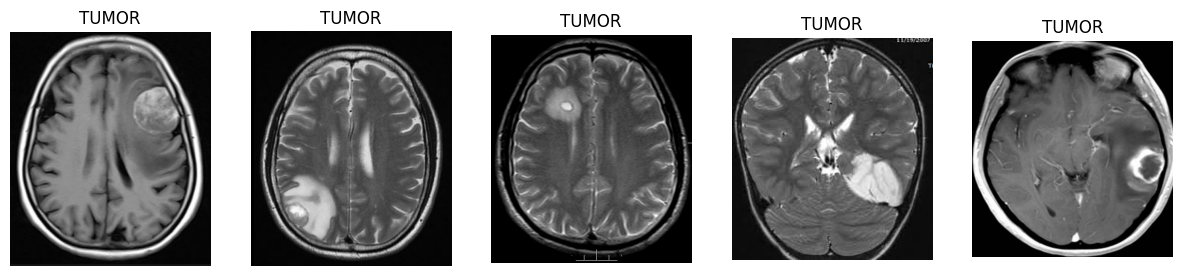

In [31]:
show_images('dataset/yes', title='TUMOR', num_images=5)

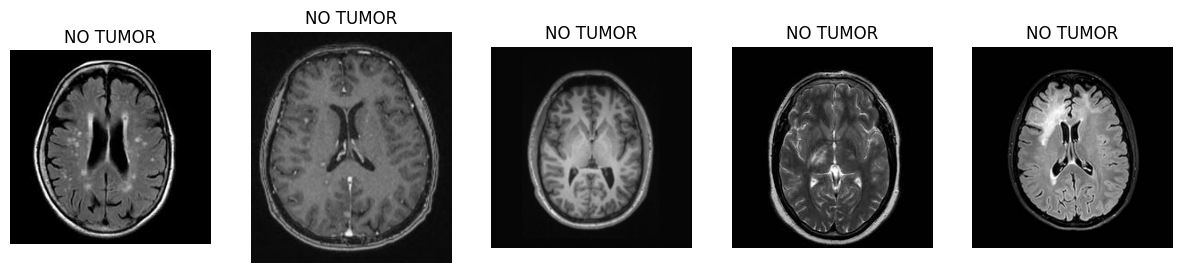

In [30]:
show_images('dataset/no', title='NO TUMOR', num_images=5)

In [3]:
IMG_SIZE = 128

tumor_dir = 'dataset/yes'
no_tumor_dir = 'dataset/no'

tumor_images, tumor_labels = preprocess_and_label_data(tumor_dir, 1, IMG_SIZE)
no_tumor_images, no_tumor_labels = preprocess_and_label_data(no_tumor_dir, 0, IMG_SIZE)

# Combine datasets
X = np.array(tumor_images + no_tumor_images)  # Features (images)
y = np.array(tumor_labels + no_tumor_labels)

X = np.array([apply_clahe(img) for img in X])

In [4]:

# Reshape to add the channel dimension
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Shape: (num_samples, 128, 128, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Training set: {X_val.shape}, Labels: {y_val.shape}")


Training set: (202, 128, 128, 1), Labels: (202,)
Training set: (51, 128, 128, 1), Labels: (51,)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    # First Conv layer
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    # Second Conv layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Third Conv layer
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten the features
    Flatten(),
    
    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevents overfitting
    Dense(1, activation='sigmoid')  # Binary classification (Tumor or No Tumor)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=10)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6174 - loss: 0.6674 - val_accuracy: 0.7451 - val_loss: 0.5386
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7561 - loss: 0.5288 - val_accuracy: 0.8039 - val_loss: 0.4668
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7553 - loss: 0.5460 - val_accuracy: 0.8235 - val_loss: 0.4263
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8083 - loss: 0.4560 - val_accuracy: 0.7843 - val_loss: 0.4458
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8171 - loss: 0.4174 - val_accuracy: 0.8431 - val_loss: 0.3807
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8683 - loss: 0.3221 - val_accuracy: 0.8824 - val_loss: 0.3248
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8806 - loss: 0.2704 - val_accuracy: 0.8824 - val_loss: 0.3710
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9498 - loss: 0.1656 - val_accuracy: 0.8824 - v

In [7]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8826 - loss: 0.7219
Validation Accuracy: 90.20%


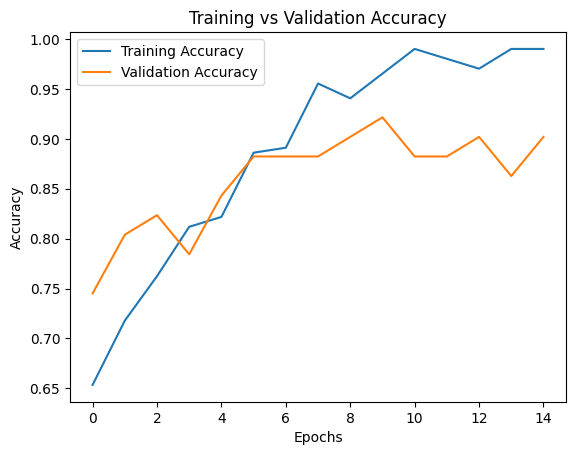

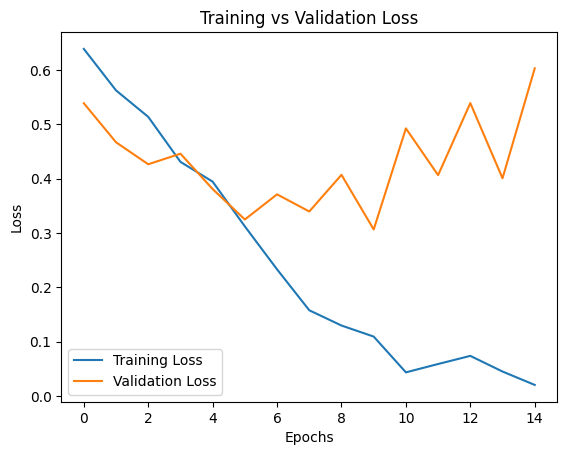

In [8]:
plot_model_info(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


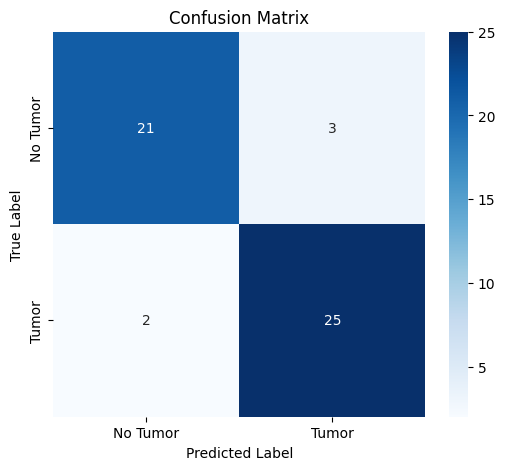


📄 Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.91      0.88      0.89        24
       Tumor       0.89      0.93      0.91        27

    accuracy                           0.90        51
   macro avg       0.90      0.90      0.90        51
weighted avg       0.90      0.90      0.90        51



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_val, y_pred, target_names=["No Tumor", "Tumor"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


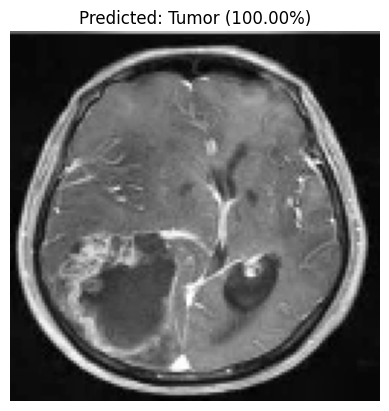

In [ ]:
# Give a new input

predict_image(model, 'dataset/yes/Y182.JPG', IMG_SIZE)